<a href="https://colab.research.google.com/github/saathwikad/Visual_Question_Answering/blob/main/VQA_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Create .kaggle directory if it doesn't exist
!mkdir ~/.kaggle

# Move the uploaded kaggle.json to ~/.kaggle/
!mv kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
# Download the dataset
!kaggle datasets download -d bhavikardeshna/visual-question-answering-computer-vision-nlp

visual-question-answering-computer-vision-nlp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
import os

# Path to the downloaded zip file
zip_file_path = 'visual-question-answering-computer-vision-nlp.zip'  # Update with your file name

# Directory to extract the contents to
extracted_dir_path = 'vqa_cv'  # Update with your desired directory name

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir_path)
print("Files extracted successfully:", extracted_files)

Files extracted successfully: ['dataset']


In [4]:
!pip install datasets
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn

In [5]:
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

In [6]:
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [7]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

<ipython-input-7-705839fc65d9>:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0
Tesla T4


In [9]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join("..", "/content/vqa_cv/dataset", "data_train.csv"),
        "test": os.path.join("..", "/content/vqa_cv/dataset", "data_eval.csv")
    }
)

with open(os.path.join("..", "/content/vqa_cv/dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

In [10]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("..", "/content/vqa_cv/dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

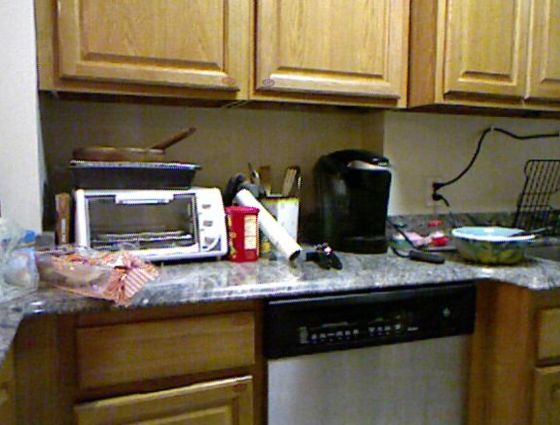

Question:	 how many electrical objects are on the cabinet
Answer:		 2 (Label: 10)


In [11]:
showExample()

In [12]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("..", "/content/vqa_cv/dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [13]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

In [14]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

In [15]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

In [16]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [17]:
import nltk
nltk.download('wordnet')
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['glass_pane', 'bucket', 'toy_box', 'toothpaste', 'hoola_hoop']
['paper_rack', 'paper_cutter', 'clothing_hamper', 'apple', 'bottle_of_liquid']
Predictions vs Labels:  0.018947368421052633
Labels vs Labels:  1.0


In [18]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

In [19]:
from transformers import  TrainingArguments
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16 = True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

In [20]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics

In [21]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 5.7829, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.32}
{'eval_loss': 5.129438877105713, 'eval_wups': 0.11396288394126913, 'eval_acc': 0.07016840417000803, 'eval_f1': 0.0009203125676632365, 'eval_runtime': 51.9056, 'eval_samples_per_second': 48.049, 'eval_steps_per_second': 1.503, 'epoch': 0.32}
{'loss': 5.048, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.64}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 4.677314281463623, 'eval_wups': 0.15427556565890965, 'eval_acc': 0.09703287890938252, 'eval_f1': 0.0028685971742600526, 'eval_runtime': 49.6489, 'eval_samples_per_second': 50.233, 'eval_steps_per_second': 1.571, 'epoch': 0.64}
{'loss': 4.7561, 'learning_rate': 4.038461538461539e-05, 'epoch': 0.96}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 4.430268287658691, 'eval_wups': 0.19221245415024107, 'eval_acc': 0.11307137129109864, 'eval_f1': 0.0035476288883213754, 'eval_runtime': 48.3827, 'eval_samples_per_second': 51.547, 'eval_steps_per_second': 1.612, 'epoch': 0.96}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 4.4487, 'learning_rate': 3.717948717948718e-05, 'epoch': 1.28}
{'eval_loss': 4.190803050994873, 'eval_wups': 0.2013111050137832, 'eval_acc': 0.14434643143544507, 'eval_f1': 0.0062958650099734365, 'eval_runtime': 50.6684, 'eval_samples_per_second': 49.222, 'eval_steps_per_second': 1.539, 'epoch': 1.28}
{'loss': 4.2543, 'learning_rate': 3.397435897435898e-05, 'epoch': 1.6}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 4.083807945251465, 'eval_wups': 0.21721515759514695, 'eval_acc': 0.14434643143544507, 'eval_f1': 0.007130558155953887, 'eval_runtime': 52.1937, 'eval_samples_per_second': 47.784, 'eval_steps_per_second': 1.494, 'epoch': 1.6}
{'loss': 4.1284, 'learning_rate': 3.0801282051282055e-05, 'epoch': 1.92}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.9943795204162598, 'eval_wups': 0.22640249297144202, 'eval_acc': 0.16519647153167602, 'eval_f1': 0.010573011213530437, 'eval_runtime': 50.6, 'eval_samples_per_second': 49.289, 'eval_steps_per_second': 1.542, 'epoch': 1.92}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 3.9961, 'learning_rate': 2.759615384615385e-05, 'epoch': 2.24}
{'eval_loss': 3.9411814212799072, 'eval_wups': 0.24178285840728117, 'eval_acc': 0.18644747393744987, 'eval_f1': 0.01285408633289366, 'eval_runtime': 52.198, 'eval_samples_per_second': 47.78, 'eval_steps_per_second': 1.494, 'epoch': 2.24}
{'loss': 3.9456, 'learning_rate': 2.4391025641025643e-05, 'epoch': 2.56}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.8639321327209473, 'eval_wups': 0.25222345018676295, 'eval_acc': 0.19687249398556536, 'eval_f1': 0.015101615542206624, 'eval_runtime': 50.2885, 'eval_samples_per_second': 49.594, 'eval_steps_per_second': 1.551, 'epoch': 2.56}
{'loss': 3.9193, 'learning_rate': 2.1185897435897437e-05, 'epoch': 2.88}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.8358211517333984, 'eval_wups': 0.25896602566690335, 'eval_acc': 0.2012830793905373, 'eval_f1': 0.016680795849878853, 'eval_runtime': 51.7237, 'eval_samples_per_second': 48.218, 'eval_steps_per_second': 1.508, 'epoch': 2.88}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 3.7516, 'learning_rate': 1.798076923076923e-05, 'epoch': 3.21}
{'eval_loss': 3.7780404090881348, 'eval_wups': 0.27277249824270977, 'eval_acc': 0.2165196471531676, 'eval_f1': 0.017476874287711452, 'eval_runtime': 49.7858, 'eval_samples_per_second': 50.095, 'eval_steps_per_second': 1.567, 'epoch': 3.21}
{'loss': 3.7565, 'learning_rate': 1.4775641025641027e-05, 'epoch': 3.53}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.752936840057373, 'eval_wups': 0.2755137290648489, 'eval_acc': 0.22012830793905372, 'eval_f1': 0.020285382120433296, 'eval_runtime': 52.3629, 'eval_samples_per_second': 47.629, 'eval_steps_per_second': 1.49, 'epoch': 3.53}
{'loss': 3.7538, 'learning_rate': 1.1570512820512822e-05, 'epoch': 3.85}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.723365068435669, 'eval_wups': 0.2772186942799755, 'eval_acc': 0.22534081796311148, 'eval_f1': 0.021241540279726395, 'eval_runtime': 53.2288, 'eval_samples_per_second': 46.854, 'eval_steps_per_second': 1.465, 'epoch': 3.85}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss': 3.5657, 'learning_rate': 8.365384615384616e-06, 'epoch': 4.17}
{'eval_loss': 3.6965842247009277, 'eval_wups': 0.2802381504091241, 'eval_acc': 0.2297514033680834, 'eval_f1': 0.02074193609559854, 'eval_runtime': 52.2876, 'eval_samples_per_second': 47.698, 'eval_steps_per_second': 1.492, 'epoch': 4.17}
{'loss': 3.5858, 'learning_rate': 5.16025641025641e-06, 'epoch': 4.49}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.682114362716675, 'eval_wups': 0.28136075052474396, 'eval_acc': 0.23215717722534082, 'eval_f1': 0.021688528927936178, 'eval_runtime': 53.573, 'eval_samples_per_second': 46.553, 'eval_steps_per_second': 1.456, 'epoch': 4.49}
{'loss': 3.534, 'learning_rate': 1.955128205128205e-06, 'epoch': 4.81}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.67533802986145, 'eval_wups': 0.28381335771750754, 'eval_acc': 0.2329591018444266, 'eval_f1': 0.02167472761551235, 'eval_runtime': 49.6798, 'eval_samples_per_second': 50.202, 'eval_steps_per_second': 1.57, 'epoch': 4.81}
{'train_runtime': 1977.118, 'train_samples_per_second': 25.224, 'train_steps_per_second': 0.789, 'train_loss': 4.1266485752203526, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 3.67533802986145, 'eval_wups': 0.28381335771750754, 'eval_acc': 0.2329591018444266, 'eval_f1': 0.02167472761551235, 'eval_runtime': 48.925, 'eval_samples_per_second': 50.976, 'eval_steps_per_second': 1.594, 'epoch': 5.0}


In [22]:

!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.3 MB/s eta 0:00:00


In [23]:
!pip install accelerate -U

In [24]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
